## Recurrent Neural Networks in Tensorflow I

### from:
### http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

### <font color='green'>Outline of the data</font>

In this post, we’ll be building a no frills RNN that accepts a binary sequence X and uses it to predict a binary sequence Y. The sequences are constructed as follows:

    Input sequence (X): At time step t, Xt has a 50% chance of being 1 (and a 50% chance of being 0). E.g., X might be [1, 0, 0, 1, 1, 1 … ].
    
    Output sequence (Y): At time step t, Yt has a base 50% chance of being 1 (and a 50% base chance to be 0). The 
    chance of Yt being 1 is increased by 50% (i.e., to 100%) if Xt−3 is 1, and decreased by 25% (i.e., to 25%) if Xt−8 is 1. If both Xt−3 and Xt−8 are 1, the chance of Yt being 1 is 50% + 50% - 25% = 75%.

Thus, there are two dependencies in the data: one at t-3 (3 steps back) and one at t-8 (8 steps back).

### Expected cross-entropy

This data is simple enough that we can calculate the expected cross-entropy loss for a trained RNN depending on whether or not it learns the dependencies:

* If the network learns no dependencies, it will correctly assign a probability of 62.5% to 1, for an expected cross-entropy loss of about 0.66.
* If the network learns only the first dependency (3 steps back) but not the second dependency, it will correctly assign a probability of 87.5%, 50% of the time, and correctly assign a probability of 62.5% the other 50% of the time, for an expected cross entropy loss of about 0.52.
* If the network learns both dependencies, it will be 100% accurate 25% of the time, correctly assign a probability of 50%, 25% of the time, and correctly assign a probability of 75%, 50% of the time, for an expected cross extropy loss of about 0.45.


In [1]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
('- learns neither dependency:', 0.66156323815798213)
('- learns first dependency:  ', 0.51916669970720941)
('- learns both dependencies: ', 0.4544543674493905)


## <font color='magenta'>First: dealing with data</font>

* <font size='3' >**Generate our binary sequences**</font>

In [2]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

* <font size='3' >**Prepare for feeding data into the graph:** *from raw data to batches*</font>

In [3]:
# adapted from 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## <font color='magenta'>Second: we will start with a vanilla RNN model</font>

<img src="http://r2rt.com/static/images/BasicRNN.png">

## ...and we will use static tf.nn.rnn so it uses lists of tensors to represent the width = num_steps

* The easiest way to represent each type of duplicate tensor (the rnn inputs, the rnn outputs (hidden state), the predictions, and the loss) is as a list of tensors

<img src="http://r2rt.com/static/images/BasicRNNLabeled.png">

In [4]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

* <font size='3' >**Set GLOBAL Configuration Variables**</font>

In [5]:
# Global config variables
num_epochs=1
num_steps = 5 # number of truncated backprop steps
batch_size = 200
num_classes = 2
state_size = 8
learning_rate = 0.1

* <font size='3' >**Defining the graph model**</font>

In [6]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs : modifications due to one-ho-encoding problems:

  1  !!! TRANSPOSE FOR THIS!!! nn_inputs is a 
      list of num_steps tensors with shape [batch_size, num_classe
  2.,. MUST be int64 !!!
  3.- add 1,0 (ONE HOT Using  0 ... 1)
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
# NEED tocast to int64
# ORIGINAL x_one_hot = tf.one_hot(x, num_classes)


x_one_hot = tf.one_hot(tf.cast(tf.transpose(x, perm=[1, 0]), tf.int64), num_classes, 1,0)

rnn_inputs = tf.unpack(tf.cast(x_one_hot, tf.float32))

* <font size='3' >**Definition of a BasicRNNCell**</font>

In [7]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell.py
"""
with tf.variable_scope('rnn_cell'):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat(1, [rnn_input, state]), W) + b)


* <font size='3' >**Adding run_cells to graph**</font>

In [8]:
"""
Adding rnn_cells to graph

This is a simplified version of the "rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

* <font size='3' >**Output y(t) (softmax) Logits and Predictions**</font>

In [9]:
"""
Predictions, loss, training step

Losses and total_loss are simlar to the "sequence_loss_by_example" and "sequence_loss"
functions, respectively, from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/seq2seq.py
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

* <font size='3' >**Loss function and training step**</font>

In [10]:
# Turn our y placeholder into a list labels
y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(1, num_steps, y)]

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logit,label) for \
          logit, label in zip(logits, y_as_list)]
losses_last=losses[-1]
total_loss = tf.reduce_mean(losses[-1])
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

## <font color='magenta'>Third: train the network</font>

* <font size='3' >**Function to train the network**</font>

In [11]:
"""
Function to train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        training_losses = []
        print("Starting for idx...")
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses_last,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

* <font size='3' >**Train the network**</font>

In [12]:
training_losses = train_network(num_epochs,num_steps,state_size)

Starting for idx...
('\nEPOCH', 0)
('Average loss at step', 100, 'for last 250 steps:', 0.59573681414127355)
('Average loss at step', 200, 'for last 250 steps:', 0.49620730370283128)
('Average loss at step', 300, 'for last 250 steps:', 0.48795114874839784)
('Average loss at step', 400, 'for last 250 steps:', 0.4861856997013092)
('Average loss at step', 500, 'for last 250 steps:', 0.48234885543584821)
('Average loss at step', 600, 'for last 250 steps:', 0.49293043345212939)
('Average loss at step', 700, 'for last 250 steps:', 0.47967623233795165)
('Average loss at step', 800, 'for last 250 steps:', 0.4848884266614914)
('Average loss at step', 900, 'for last 250 steps:', 0.48608504503965377)


* <font size='3' >**Plotting training losses**</font>

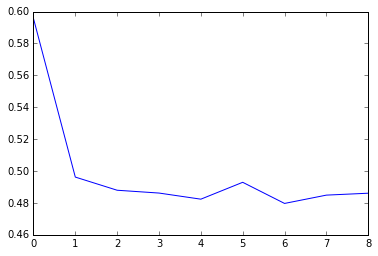

In [13]:
plt.plot(training_losses)

## <font color='magenta'>Finally: improve the model playing with hyperparameters num_steps state_size</font>

* <font size='3' >**And try to understand your results!**</font>

## then...see next Notebook ...translating our model to Tensorflow